# Exploratory Analysis

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import utils

cwd = os.getcwd()
#import mplhep as hep
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})
%load_ext autoreload
%autoreload 2

In [2]:
# parameters
bw = 1

In [3]:
# Load the ROOT file
file_paths = [f"../proj/GamGam/Data/data_{x}.GamGam.root" for x in ['A', 'B', 'C', 'D']]  # Update with your file path
tree_name = "mini"  # The tree name based on the provided data structure

In [4]:
# Example usage
# file_paths = [...]  # List of file paths to process
tree_name = "mini"  # Replace with your actual tree name
combined_df = utils.process_files_parallel(file_paths)


100%|██████████| 4/4 [02:36<00:00, 39.16s/it]


In [5]:
# Process all files and get the resulting DataFrame
df_A = utils.process_files_parallel([file_paths[0]])

100%|██████████| 1/1 [00:18<00:00, 18.17s/it]


In [6]:
combined_df.head()

,runNumber,eventNumber,invariant_mass,photon_isTightID,photon_ptcone30,photon_etcon20,photon_trigMatched,jet_n,lep_n,met_et,met_phi
0,297730,1540777,170.207956,"[False, False]","[0.0, 54738.84765625]","[1209.197265625, 575.0435791015625]","[True, True]",4,0,46997.636719,1.633800
1,297730,1713779,110.461619,"[False, False]","[5506.99169921875, 11680.0419921875]","[5396.2333984375, 2005.253173828125]","[True, True]",0,0,28530.031250,-2.313051
2,297730,1761929,79.565279,"[False, False]","[3902.340576171875, 16578.07421875]","[3261.8388671875, 21145.14453125]","[True, True]",3,0,11786.607422,2.009590
3,297730,1765304,65.320374,"[True, True]","[0.0, 0.0]","[-23.805450439453125, -614.49365234375]","[True, True]",0,0,53329.449219,-1.516588
4,297730,1651552,74.342131,"[False, False]","[8417.5751953125, 0.0]","[2472.8896484375, 495.9525451660156]","[True, True]",2,0,81126.132812,3.051861


In [7]:
combined_df.shape

(7772074, 11)

In [8]:
fltr = False
if filter:
    filtered_df = combined_df[
    (combined_df['photon_isTightID'].apply(lambda x: x == [True, True])) &  # Both photons are tight
    (combined_df['photon_ptcone30'].apply(lambda x: min(x) > 25)) &              # Both photons have pt > 25 GeV
    (combined_df['jet_n'] >= 2) &                                          # At least two jets
    (combined_df['met_et'] > 30) &                                         # Missing ET > 30 GeV
    (combined_df['invariant_mass'].between(100, 150))                      # Invariant mass between 110 and 140 GeV
    ]
else:
    filtered_df = combined_df
    filtered_A = df_A

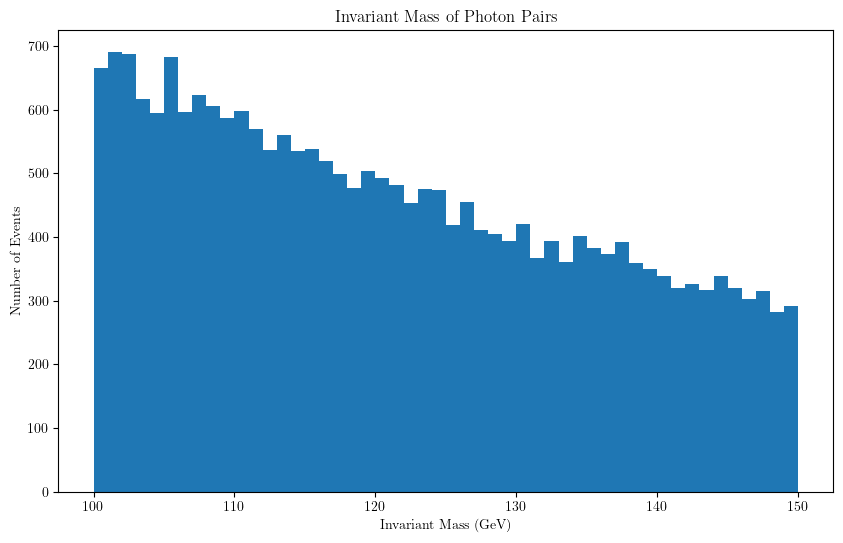

In [9]:
plt.figure(figsize=(10, 6))
counts, bin_edges, _ =  plt.hist(filtered_df["invariant_mass"], bins=np.arange(100, 150 + bw, bw))
plt.title('Invariant Mass of Photon Pairs')
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Number of Events')
plt.show()

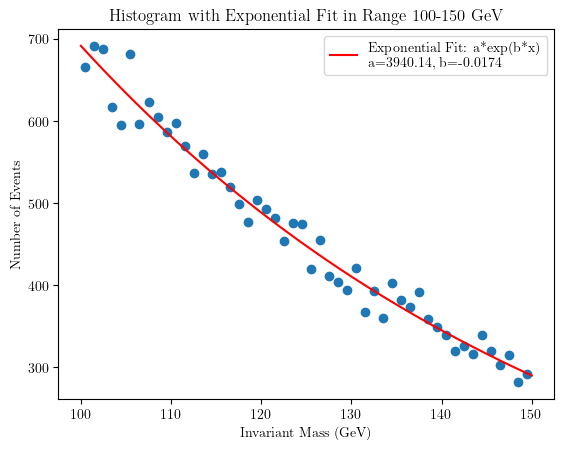

In [10]:
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
popt, pcov = utils.fit_histogram_exponential(counts, bin_edges, range_fit=(100, 150))

In [11]:
plt.figure(figsize=(10, 6))
counts_A, bin_edges_A, _ =  plt.hist(filtered_A["invariant_mass"], bins=np.arange(100, 150 + bw, bw))
plt.title('Invariant Mass of Photon Pairs')
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Number of Events')
plt.show()

NameError: name 'filtered_A' is not defined

<Figure size 1000x600 with 0 Axes>

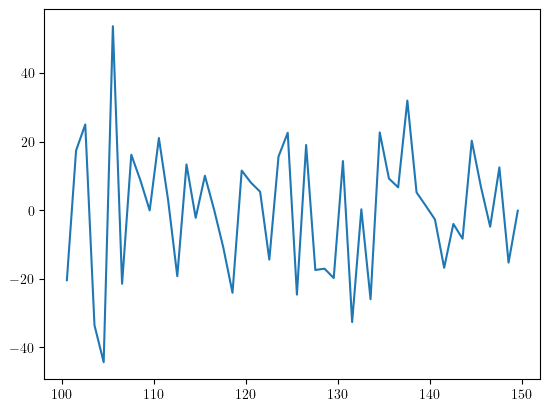

In [ ]:
plt.plot(bin_centers, counts-utils.exponential_fit(bin_centers, *popt))

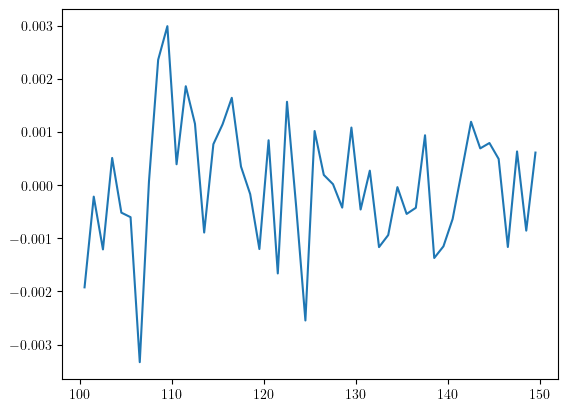

In [ ]:
plt.plot(bin_centers, counts/sum(counts)-counts_A/sum(counts_A))

# Deprec

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import utils

cwd = os.getcwd()
#import mplhep as hep
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})
%load_ext autoreload
%autoreload 2

In [2]:
file_paths = [f"../proj/GamGam/Data/data_{x}.GamGam.root" for x in ['A', 'B', 'C', 'D']]  # Update with your file path
tree_name = "mini"  # The tree name based on the provided data structure
bw=3
lower, upper = 110, 140
#datasets = [file_paths[1]]
#bw=1.5
#lower, upper = 110, 140
datasets = file_paths

In [3]:
# Open the ROOT file and access the tree
invariant_masses = []
for file_path in datasets:
    with uproot.open(file_path) as file:
        tree = file[tree_name]

        # Read the branches for photon data
        photon_E = tree["photon_E"].array(library="np")
        photon_pt = tree["photon_pt"].array(library="np")
        photon_eta = tree["photon_eta"].array(library="np")
        photon_phi = tree["photon_phi"].array(library="np")

    # Initialize a list to store the invariant masses

    # Loop through each event to calculate the invariant mass
    for E, pt, eta, phi in zip(photon_E, photon_pt, photon_eta, photon_phi):
        if len(E) >= 2:  # Ensure there are at least two photons in the event
            # Sort photons by energy if needed
            sorted_indices = np.argsort(E)[::-1]
            E = E[sorted_indices]
            pt = pt[sorted_indices]
            eta = eta[sorted_indices]
            phi = phi[sorted_indices]

            # Calculate px, py, pz from pt, eta, phi
            px = pt * np.cos(phi)
            py = pt * np.sin(phi)
            pz = pt * np.sinh(eta)

            # Calculate the invariant mass of the two leading photons
            E1, E2 = E[0], E[1]
            px1, px2 = px[0], px[1]
            py1, py2 = py[0], py[1]
            pz1, pz2 = pz[0], pz[1]
            
            # Ensure energies are positive
            if E1 > 0 and E2 > 0:
                # Calculate the invariant mass
                invariant_mass = np.sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
                invariant_masses.append(invariant_mass/1000)



In [4]:

# Assuming file_path and tree_name are defined
with uproot.open(file_path) as file:
    tree = file[tree_name]

    # Read branches for photon data
    photon_E = tree["photon_E"].array(library="np")
    photon_pt = tree["photon_pt"].array(library="np")
    photon_eta = tree["photon_eta"].array(library="np")
    photon_phi = tree["photon_phi"].array(library="np")

# Calculate maximum invariant masses of photon pairs for each event
max_invariant_masses = []

for E, pt, eta, phi in zip(photon_E, photon_pt, photon_eta, photon_phi):
    if len(E) >= 2:  # At least two photons required
        # Sort photons by energy
        sorted_indices = np.argsort(E)[::-1]
        E, pt, eta, phi = E[sorted_indices], pt[sorted_indices], eta[sorted_indices], phi[sorted_indices]

        # Convert from (pt, eta, phi) to Cartesian coordinates (px, py, pz)
        px = pt * np.cos(phi)
        py = pt * np.sin(phi)
        pz = pt * np.sinh(eta)

        # Calculate invariant mass of all possible photon pairs
        _invariant_masses = []
        for i in range(len(E)):
            for j in range(i + 1, len(E)):
                E1, E2 = E[i], E[j]
                px1, px2 = px[i], px[j]
                py1, py2 = py[i], py[j]
                pz1, pz2 = pz[i], pz[j]

                if E1 > 0 and E2 > 0:  # Valid energies check
                    invariant_mass = np.sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
                    _invariant_masses.append(invariant_mass / 1000)  # Convert to GeV

        if invariant_masses:
            # Store only the maximum invariant mass for the event
            max_invariant_masses.append(max(_invariant_masses))

/tmp/ipykernel_2582/1084261139.py:35: RuntimeWarning: invalid value encountered in sqrt
  invariant_mass = np.sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)


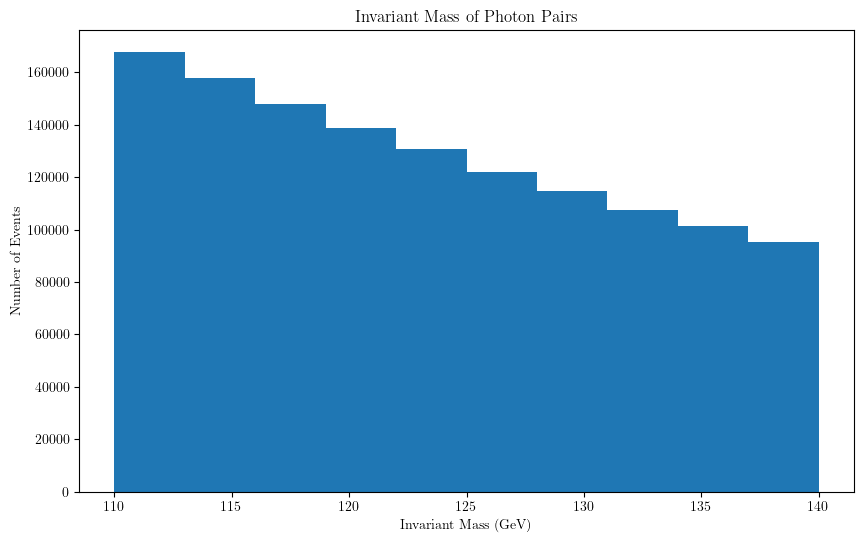

In [5]:
# Plot the invariant mass distribution
if invariant_masses:
    plt.figure(figsize=(10, 6))
    counts, bin_edges, _ =  plt.hist(invariant_masses, bins=np.arange(lower, upper + bw, bw))
    plt.title('Invariant Mass of Photon Pairs')
    plt.xlabel('Invariant Mass (GeV)')
    plt.ylabel('Number of Events')
    plt.show()
else:
    print("No invariant masses were calculated. Check data and computations.")

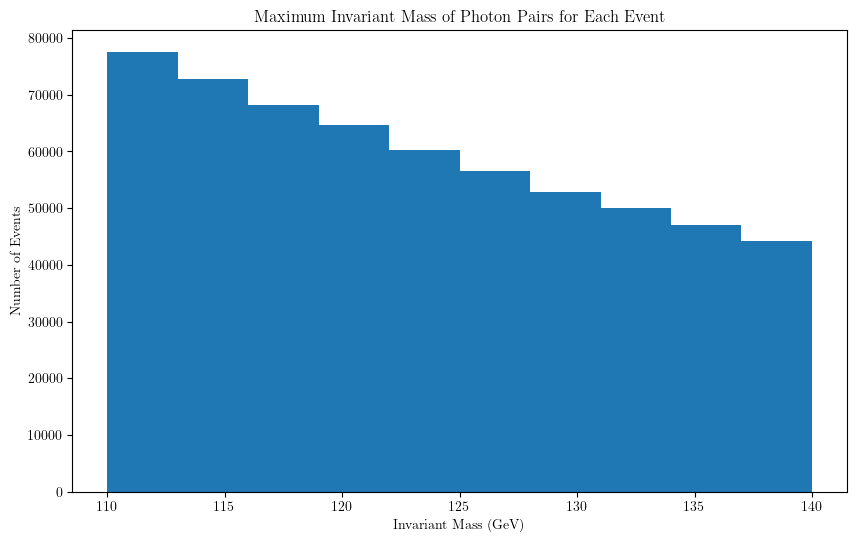

In [6]:
# Plot the maximum invariant mass distribution
if max_invariant_masses:
    plt.figure(figsize=(10, 6))
    max_counts, max_bin_edges, _ = plt.hist(max_invariant_masses, bins=np.arange(lower, upper + bw, bw))
    plt.title('Maximum Invariant Mass of Photon Pairs for Each Event')
    plt.xlabel('Invariant Mass (GeV)')
    plt.ylabel('Number of Events')
    plt.show()
else:
    print("No invariant masses were calculated. Check data and computations.")

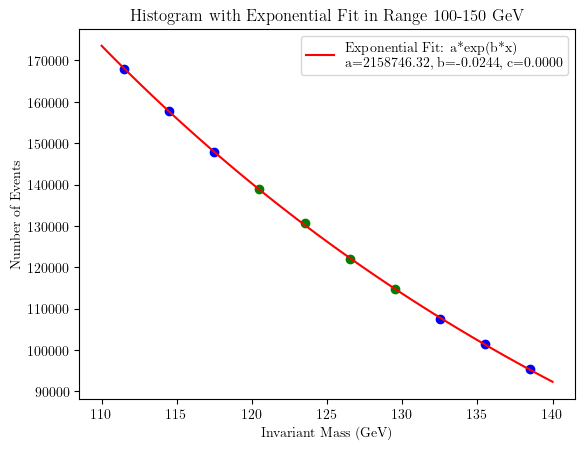

In [7]:
# Example usage:
# Assuming 'max_invariant_masses' contains the data from the previous step
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
popt, pcov = utils.fit_histogram_exponential_poly(counts, bin_edges, range_fit=(lower, upper), ign_window=[120,130])


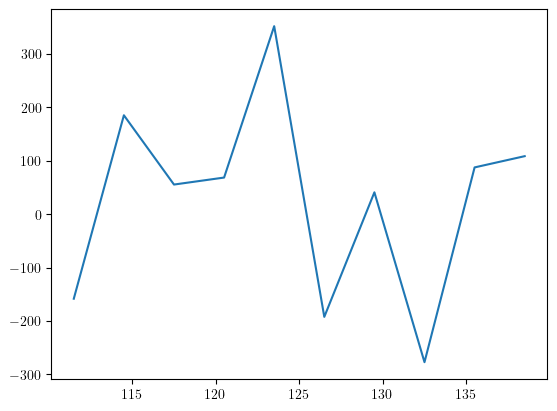

In [8]:
plt.plot(bin_centers, counts-utils.exponential_poly_fit(bin_centers, *popt))

# Sliding block count??

In [9]:
invariant_masses.sort()
invariant_masses

[0.015025770017216772,
 0.06790623157428995,
 0.08028976149411113,
 0.08146848778486762,
 0.08785476178034102,
 0.10734141702795949,
 0.11285947525207976,
 0.1595989346652698,
 0.16092842634084575,
 0.17153369683737305,
 0.19329768894509233,
 0.20574117155358382,
 0.23247337884572555,
 0.24826670180394586,
 0.2586422894812081,
 0.2643771187338915,
 0.2919467536180007,
 0.33211503719940166,
 0.3322205195784839,
 0.3584241769112157,
 0.36025504404808123,
 0.3695472680392552,
 0.3819713283583811,
 0.3887060722039692,
 0.40101827877555574,
 0.4014279382247857,
 0.4061692083689092,
 0.4213811523929862,
 0.4433591040016724,
 0.4552116363256578,
 0.483058573012567,
 0.48451759210384243,
 0.4849384407853417,
 0.49128081774542454,
 0.5051517745117386,
 0.5144431563877342,
 0.5219811821245929,
 0.5248093565164934,
 0.5423548986082005,
 0.5493481201539687,
 0.5652500402086962,
 0.5705928796257737,
 0.5780594742743517,
 0.6120450119687871,
 0.612160260129675,
 0.6382832298369501,
 0.64086359407942

In [11]:
from tqdm import tqdm
def count_masses_rectangle(invariant_masses, bandwidth=5):
    invariant_masses = np.array(invariant_masses)
    n = int(np.max(invariant_masses)- bandwidth)
    x = np.arange(n) + bandwidth / 2
    y = []
    for i in range(n):
        count = np.sum(np.bitwise_and((invariant_masses > i),(invariant_masses <= i+bandwidth)))
        y.append(count)
    return np.array(x), np.array(y)

def count_masses_rectangle_disj(invariant_masses, bandwidth=5):
    invariant_masses = np.array(invariant_masses)
    n = int(np.max(invariant_masses)- bandwidth)
    x = np.arange(n) + bandwidth / 2
    y = []
    for i in range(n):
        count = np.sum(np.bitwise_and((invariant_masses > i*bandwidth),(invariant_masses <= (i+1)*bandwidth)))
        y.append(count)
    return np.array(x), np.array(y)

def epanechnikov_kernel(x, x_center, bandwidth):
    u = (x - x_center) / bandwidth
    # Only consider values of u within [-1, 1]
    mask = np.abs(u) <= 1
    kernel_values = 0.75 * (1 - u[mask]**2)
    return np.sum(kernel_values)

def count_masses_epanechnikov(invariant_masses, bandwidth=3):
    invariant_masses = np.array(invariant_masses)
    n = int(np.max(invariant_masses) - bandwidth)
    x = np.arange(n) + bandwidth / 2
    y = []

    for i in tqdm(range(n)):
        count = epanechnikov_kernel(invariant_masses, i + bandwidth / 2, bandwidth)
        y.append(count)
    
    return np.array(x), np.array(y)

In [11]:
#x, y = count_masses(invariant_masses,bandwidth=2)
x, y = count_masses_epanechnikov(invariant_masses, bandwidth=3)

100%|██████████| 4449/4449 [01:44<00:00, 42.70it/s]


In [12]:
lower, upper = 110, 160

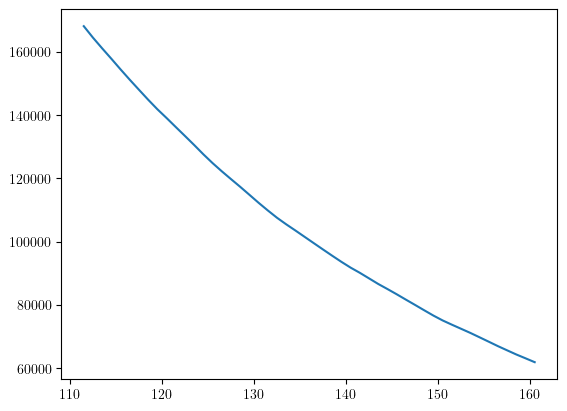

In [13]:
plt.plot(x[lower:upper],y[lower:upper])

In [14]:
from scipy.optimize import curve_fit
# Define the function to fit
def model(x, a, b, c):
    return a * np.exp(b * x + c * x**2)
popt, pcov = curve_fit(model, x[lower:upper], y[lower:upper], p0=(50000, -0.01, 0))


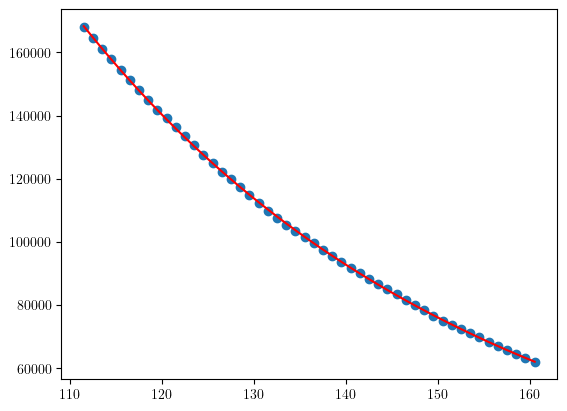

In [15]:
plt.scatter(x[lower:upper],y[lower:upper])
plt.plot(x[lower:upper], model(x[lower:upper], *popt), label='Fitted function', color='r')

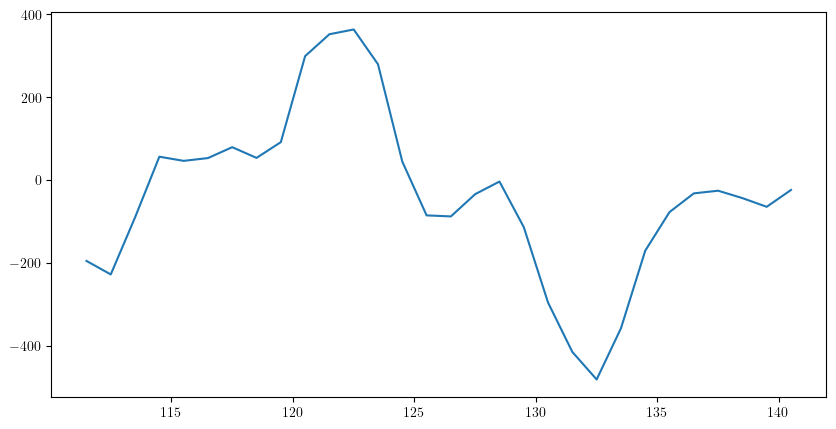

In [16]:
fig = plt.figure()
fig.set_size_inches((10,5))
pl_lower, pl_upper = 110,140
plt.plot(x[pl_lower:pl_upper],y[pl_lower:pl_upper]-model(x[pl_lower:pl_upper], *popt))


# Whole Stuff filtered

Total events: 7798424
Events with at least two tight photons: 979059
Events with isolated photons: 979059
Events with valid jet and MET criteria: 161249
Selected events within mass window: 161249


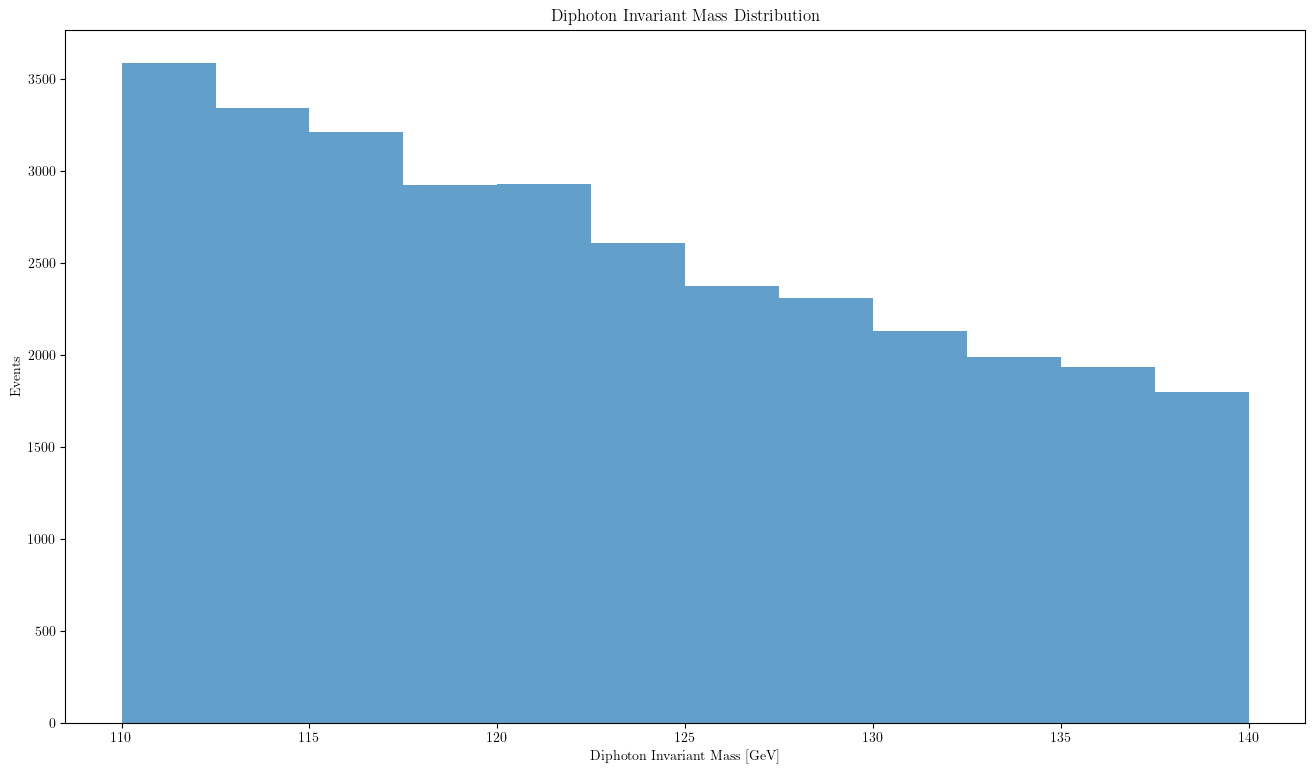

In [23]:
# Initialize lists to store results
invariant_masses = []
total_events = 0
tight_photons_count = 0
isolated_photons_count = 0
valid_jet_met_count = 0

# Loop through each dataset file
for file_path in datasets:
#for file_path in [datasets[1]]:
    with uproot.open(file_path) as file:
        tree = file[tree_name]

        # Read the branches for photon data
        photon_E = tree["photon_E"].array(library="np")
        photon_pt = tree["photon_pt"].array(library="np")
        photon_eta = tree["photon_eta"].array(library="np")
        photon_phi = tree["photon_phi"].array(library="np")
        photon_isTightID = tree["photon_isTightID"].array(library="np")
        photon_ptcone30 = tree["photon_ptcone30"].array(library="np")
        photon_etcone20 = tree["photon_etcone20"].array(library="np")
        jet_n = tree["jet_n"].array(library="np")
        met_et = tree["met_et"].array(library="np")

    # Total number of events
    total_events += len(photon_E)

    # Loop through each event to calculate the invariant mass and apply filters
    for E, pt, eta, phi, isTight, ptcone30, etcone20, jet_count, met in zip(
        photon_E, photon_pt, photon_eta, photon_phi, photon_isTightID, photon_ptcone30, photon_etcone20, jet_n, met_et):

        # Filter for events with at least two photons
        if len(E) >= 2 and isTight[0] and isTight[1]:  # Both photons must be "tight"
            tight_photons_count += 1  # Count events passing the tight filter

            # Apply photon isolation criteria
            if True:#ptcone30[0] < 5.0 and etcone20[0] < 5.0 :#and ptcone30[1] < 5.0 and etcone20[1] < 5.0:
                isolated_photons_count += 1  # Count events passing the isolation filter

                # Optional: filter for events with zero jets and low missing transverse energy
                if jet_count ==0 and met/1000 < 25:
                    valid_jet_met_count += 1  # Count events passing jet and MET filter

                    # Sort photons by energy if needed
                    sorted_indices = np.argsort(E)[::-1]
                    E = E[sorted_indices]
                    pt = pt[sorted_indices]
                    eta = eta[sorted_indices]
                    phi = phi[sorted_indices]

                    # Calculate px, py, pz from pt, eta, phi
                    px = pt * np.cos(phi)
                    py = pt * np.sin(phi)
                    pz = pt * np.sinh(eta)

                    # Calculate the invariant mass of the two leading photons
                    E1, E2 = E[0], E[1]
                    px1, px2 = px[0], px[1]
                    py1, py2 = py[0], py[1]
                    pz1, pz2 = pz[0], pz[1]

                    # Ensure energies are positive
                    if E1 > 0 and E2 > 0:
                        # Calculate the invariant mass
                        invariant_mass = np.sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
                        invariant_mass /= 1000  # Convert to GeV

                        # Filter events within the mass window
                        if True:#lower <= invariant_mass <= upper:
                            invariant_masses.append(invariant_mass)

# Debugging output
print(f"Total events: {total_events}")
print(f"Events with at least two tight photons: {tight_photons_count}")
print(f"Events with isolated photons: {isolated_photons_count}")
print(f"Events with valid jet and MET criteria: {valid_jet_met_count}")
print(f"Selected events within mass window: {len(invariant_masses)}")

# Plot the invariant mass distribution
fig = plt.figure()
fig.set_size_inches((16,9))
plt.hist(invariant_masses, bins=int((upper - lower) / bw), range=(lower, upper), alpha=0.7)
plt.xlabel('Diphoton Invariant Mass [GeV]')
plt.ylabel('Events')
plt.title('Diphoton Invariant Mass Distribution')
#plt.savefig('manual_filtered_distribution_all.pdf')
plt.show()


  0%|          | 0/2448 [00:00<?, ?it/s]

100%|██████████| 2448/2448 [00:00<00:00, 4908.32it/s]
/tmp/ipykernel_2582/2812055190.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * x + c*x**2)


[ 1.04929744e+05 -3.41108057e-02  3.44540856e-05]


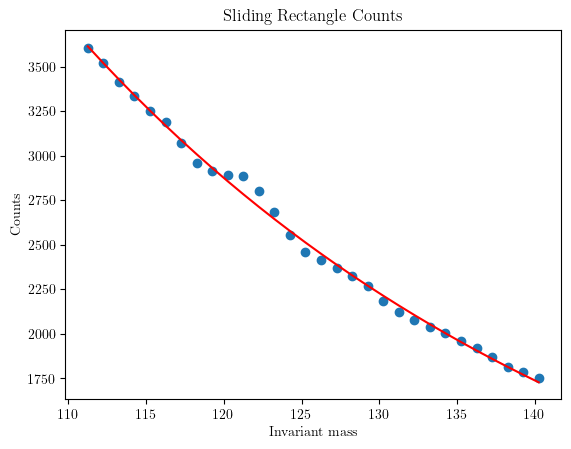

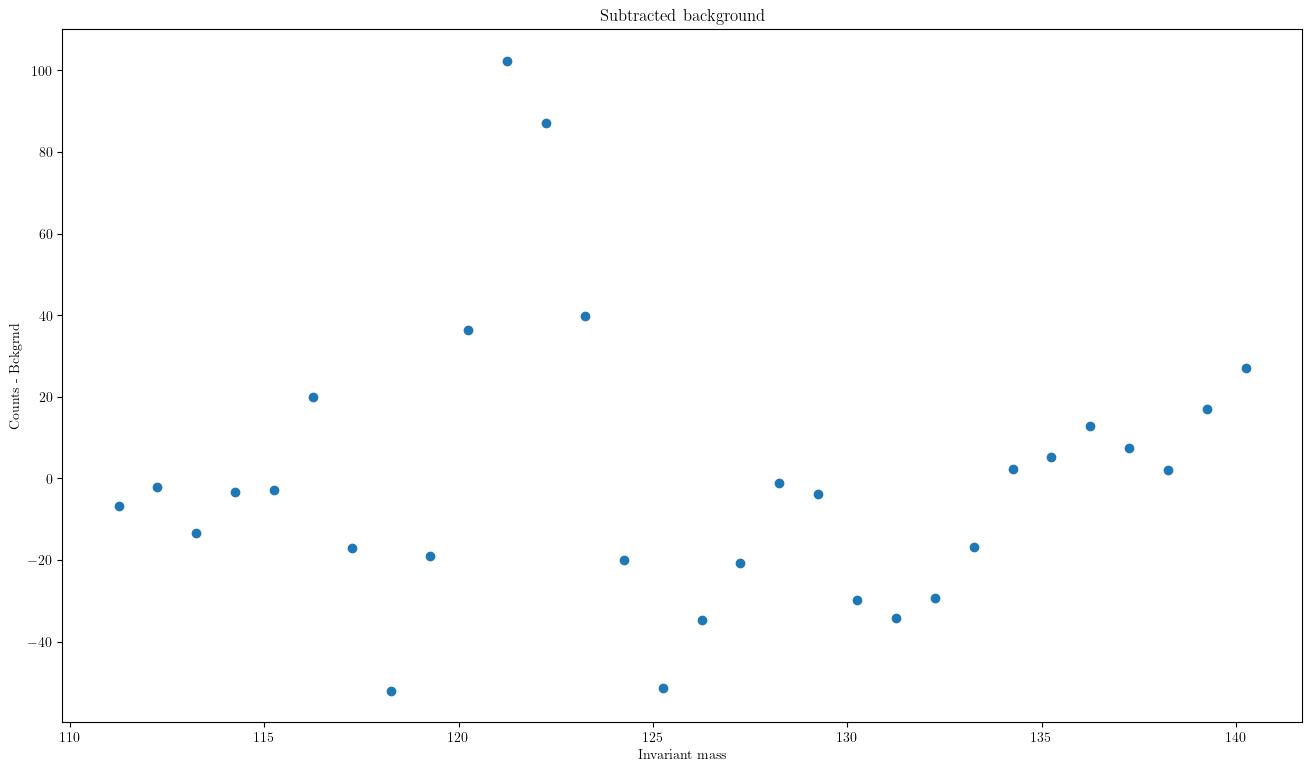

In [24]:
bw=2.5
x, y = count_masses_epanechnikov(invariant_masses, bandwidth=bw)
#x, y = count_masses_rectangle(invariant_masses, bandwidth=bw)
lower, upper = 110, 140
def model(x, a, b, c):
    return a * np.exp(b * x + c*x**2)
popt, pcov = curve_fit(model, x[lower:upper], y[lower:upper], p0=(50000, -0.01, -0.001))
print(popt)
plt.title('Sliding Rectangle Counts')
fig.set_size_inches((16,9))
plt.xlabel('Invariant mass')
plt.ylabel('Counts')
plt.scatter(x[lower:upper],y[lower:upper])
plt.plot(x[lower:upper], model(x[lower:upper], *popt), label='Fitted function', color='r')
#plt.savefig('manual_filtered_rectangle.pdf')
plt.show()
fig = plt.figure()
plt.title('Subtracted background')
plt.xlabel('Invariant mass')
plt.ylabel('Counts - Bckgrnd')
fig.set_size_inches((16,9))
pl_lower, pl_upper = 110,140
plt.scatter(x[pl_lower:pl_upper],y[pl_lower:pl_upper]-model(x[pl_lower:pl_upper], *popt))
#plt.savefig('manual_filtered_rectangle_detrended.pdf')
plt.show()

[121.69189491   0.85573647 111.78814937]


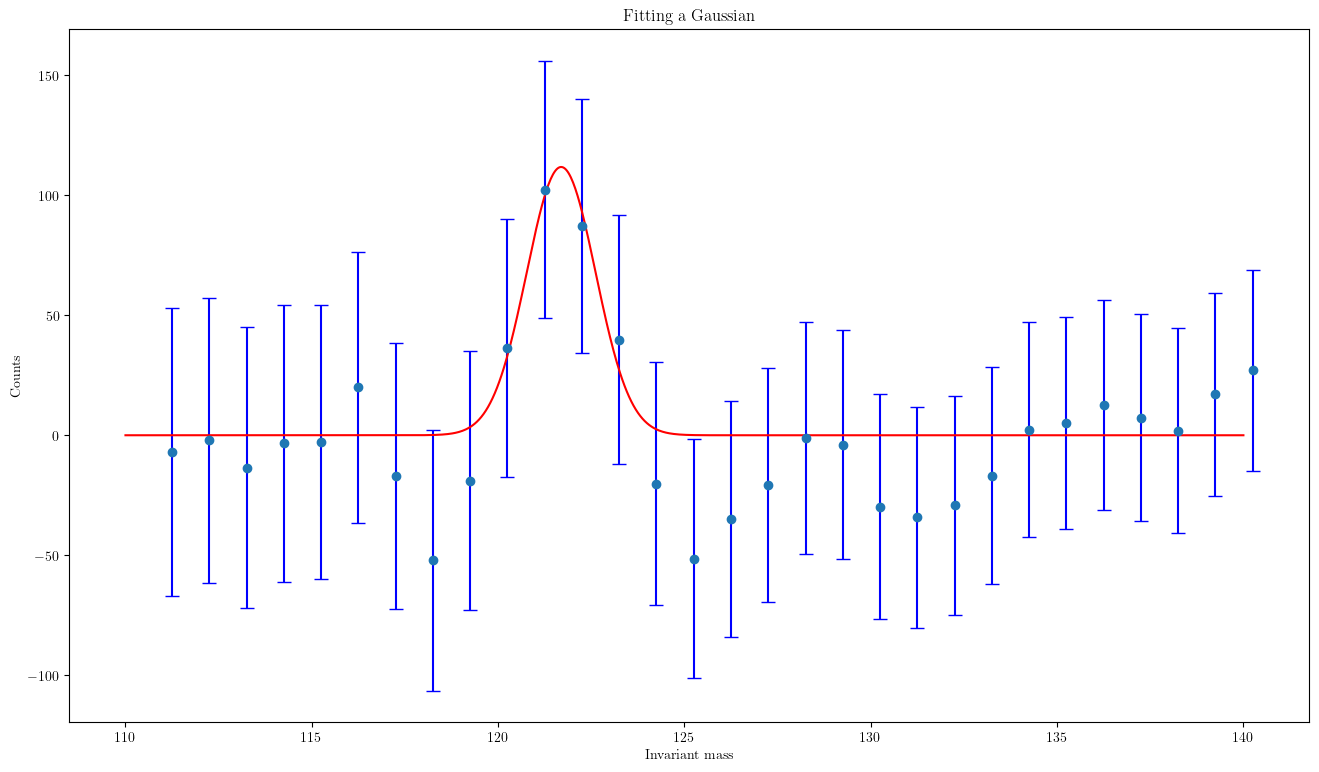

In [25]:
def gauß(x,a,b,c):
    return np.exp(-(x-a)**2/(2*b))*c
gx = x[pl_lower:pl_upper]
gy = y[pl_lower:pl_upper]-model(x[pl_lower:pl_upper], *popt)
gpopt, gpcov = curve_fit(gauß, gx, gy, p0=(122, 1, 50))
print(gpopt)
fig = plt.figure()
fig.set_size_inches((16,9))
plt.title('Fitting a Gaussian')
plt.xlabel('Invariant mass')
plt.ylabel('Counts')
plt.errorbar(x[pl_lower:pl_upper],y[pl_lower:pl_upper]-model(x[pl_lower:pl_upper], *popt), yerr=np.sqrt(y[pl_lower:pl_upper]), fmt='o', ecolor='b', capsize=5, label='Asymmetrical error bars')

plt.plot(np.linspace(pl_lower,pl_upper,1000), gauß(np.linspace(pl_lower,pl_upper,1000), *gpopt), label='Fitted Gaussian', color='r')
#plt.savefig('manual_rectangle_gaußfit.pdf')

plt.show()

In [27]:
import pickle as pkl
with open('xy.pkl', 'wb') as f:
    pkl.dump([x,y], f)

# XGB

In [71]:
import json
import xgboost as xgb
import pickle as pkl
import pandas as pd

In [86]:
with open('split_combined_df.pkl', 'rb') as f:
    df_old = pkl.load(f)

In [87]:
df_old[['trigMatched_1', 'trigMatched_2']] = pd.DataFrame(df_old['photon_trigMatched'].tolist(), index=df.index)
df = df_old.drop('photon_trigMatched', axis=1)
df = df.drop(columns=['runNumber', 'eventNumber','met_phi', 'invariant_mass'])
df

,jet_n,lep_n,met_et,photon1_isTightID,photon2_isTightID,photon1_ptcone30,photon2_ptcone30,photon1_etcon20,photon2_etcon20,trigMatched_1,trigMatched_2
0,4,0,46997.636719,0.0,0.0,0.000000,54738.847656,1209.197266,575.043579,True,True
1,0,0,28530.031250,0.0,0.0,5506.991699,11680.041992,5396.233398,2005.253174,True,True
2,3,0,11786.607422,0.0,0.0,3902.340576,16578.074219,3261.838867,21145.144531,True,True
3,0,0,53329.449219,1.0,1.0,0.000000,0.000000,-23.805450,-614.493652,True,True
4,2,0,81126.132812,0.0,0.0,8417.575195,0.000000,2472.889648,495.952545,True,True
...,...,...,...,...,...,...,...,...,...,...,...
7772069,2,0,57385.390625,0.0,1.0,29725.947266,2197.285645,12817.910156,2040.245361,True,True
7772070,2,0,29234.447266,1.0,1.0,17133.960938,0.000000,15516.250000,-138.102783,True,True
7772071,2,0,43723.125000,1.0,0.0,3342.473389,3580.862305,3575.357666,-335.848083,True,True
7772072,2,0,22795.544922,1.0,0.0,13440.083008,8577.980469,1129.059082,1378.617432,True,True


In [88]:
xtrain = xgb.DMatrix(df)

In [146]:
#bst = xgb.Booster()
#bst.load_model('xgb_model.json')
bst = xgb.Booster()
bst.load_model('xgb_model_brachial.json')

In [147]:
bst.predict(xtrain)

array([2.7140537e-01, 4.2146170e-05, 3.4871741e-04, ..., 2.9902183e-02,
       1.6177224e-03, 1.7685696e-02], dtype=float32)

In [148]:
weight_df = pd.DataFrame()
weight_df['invariant_mass'] = df_old['invariant_mass']
weight_df['prob'] = bst.predict(xtrain)
weight_df

,invariant_mass,prob
0,170.207956,0.271405
1,110.461619,0.000042
2,79.565279,0.000349
3,65.320374,0.691832
4,74.342131,0.006036
...,...,...
7772069,72.837061,0.003078
7772070,77.775556,0.048689
7772071,144.514936,0.029902
7772072,149.009415,0.001618


In [149]:
from tqdm import tqdm

In [150]:
def count_masses_rectangle_weight(invariant_masses, weights, bandwidth=5):
    invariant_masses = np.array(invariant_masses)
    n = int(np.max(invariant_masses)- bandwidth)
    x = np.arange(n) + bandwidth / 2
    y = []
    for i in tqdm(range(n)):
        mask = np.bitwise_and((invariant_masses > i),(invariant_masses <= i+bandwidth))
        count = np.sum(weights[mask])
        y.append(count)
    return np.array(x), np.array(y)

def count_masses_rectangle_weight_disj(invariant_masses, weights, bandwidth=5):
    invariant_masses = np.array(invariant_masses)
    n = int(np.max(invariant_masses)- bandwidth)
    x = np.arange(n) + bandwidth / 2
    y = []
    for i in tqdm(range(n)):
        mask = np.bitwise_and((invariant_masses > i*bandwidth),(invariant_masses <= (i+1)*bandwidth))
        count = np.sum(weights[mask])
        y.append(count)
    return np.array(x), np.array(y)


def epanechnikov_kernel_weights(x, x_center, weights, bandwidth):
    u = (x - x_center) / bandwidth
    # Only consider values of u within [-1, 1]
    mask = np.abs(u) <= 1
    kernel_values = 0.75 * (1 - u[mask]**2) * weights[mask]
    return np.sum(kernel_values)

def count_masses_epanechnikov_weight(invariant_masses, weights, bandwidth=3):
    invariant_masses = np.array(invariant_masses)
    n = int(np.max(invariant_masses) - bandwidth)
    x = np.arange(n) + bandwidth / 2
    y = []

    for i in tqdm(range(n)):
        count = epanechnikov_kernel_weights(invariant_masses, i + bandwidth / 2, weights, bandwidth)
        y.append(count)
    
    return np.array(x), np.array(y)

In [167]:
bw=1.5
x, y = count_masses_epanechnikov_weight(weight_df['invariant_mass'], weight_df['prob'], bandwidth=bw)
#x, y = count_masses_rectangle_weight_disj(weight_df['invariant_mass'], weight_df['prob'], bandwidth=bw)


100%|██████████| 4451/4451 [02:44<00:00, 27.04it/s]


[ 2.47572141e+05 -3.82463002e-02  5.33919381e-05]


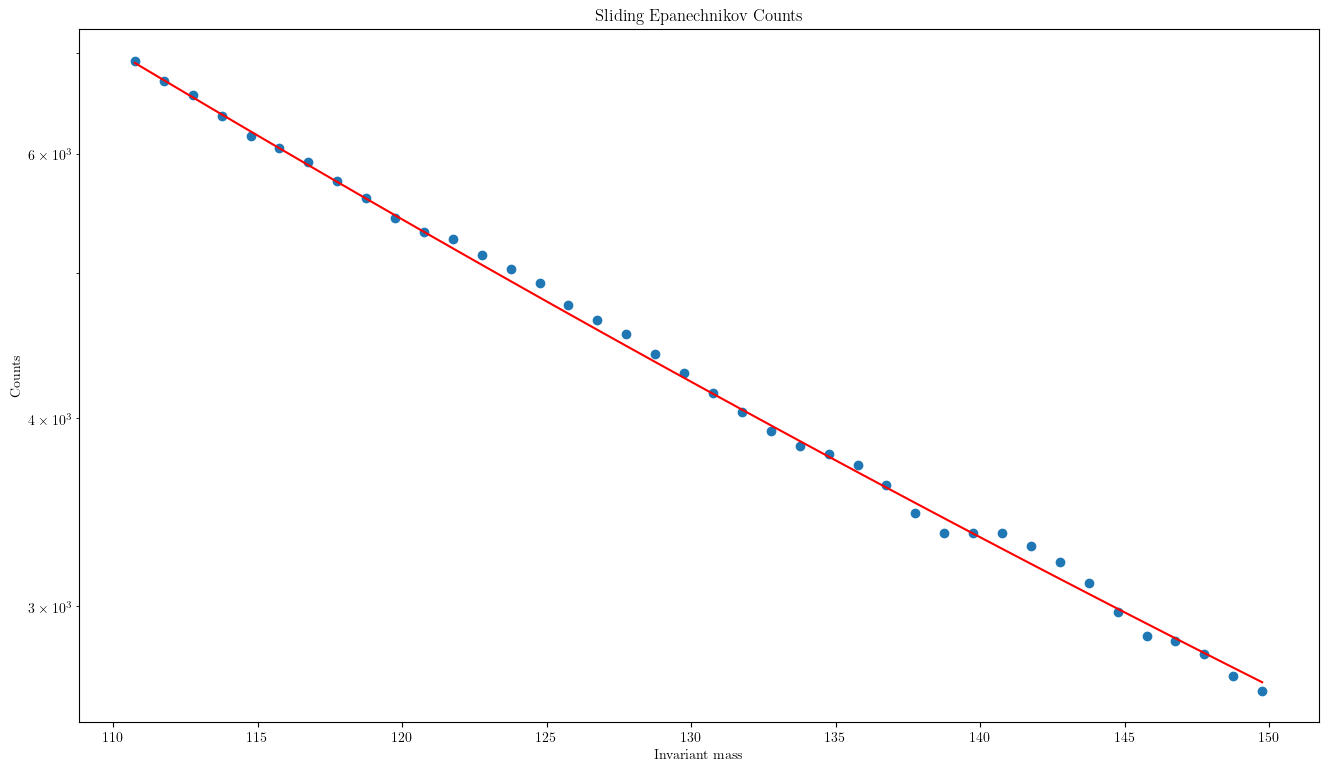

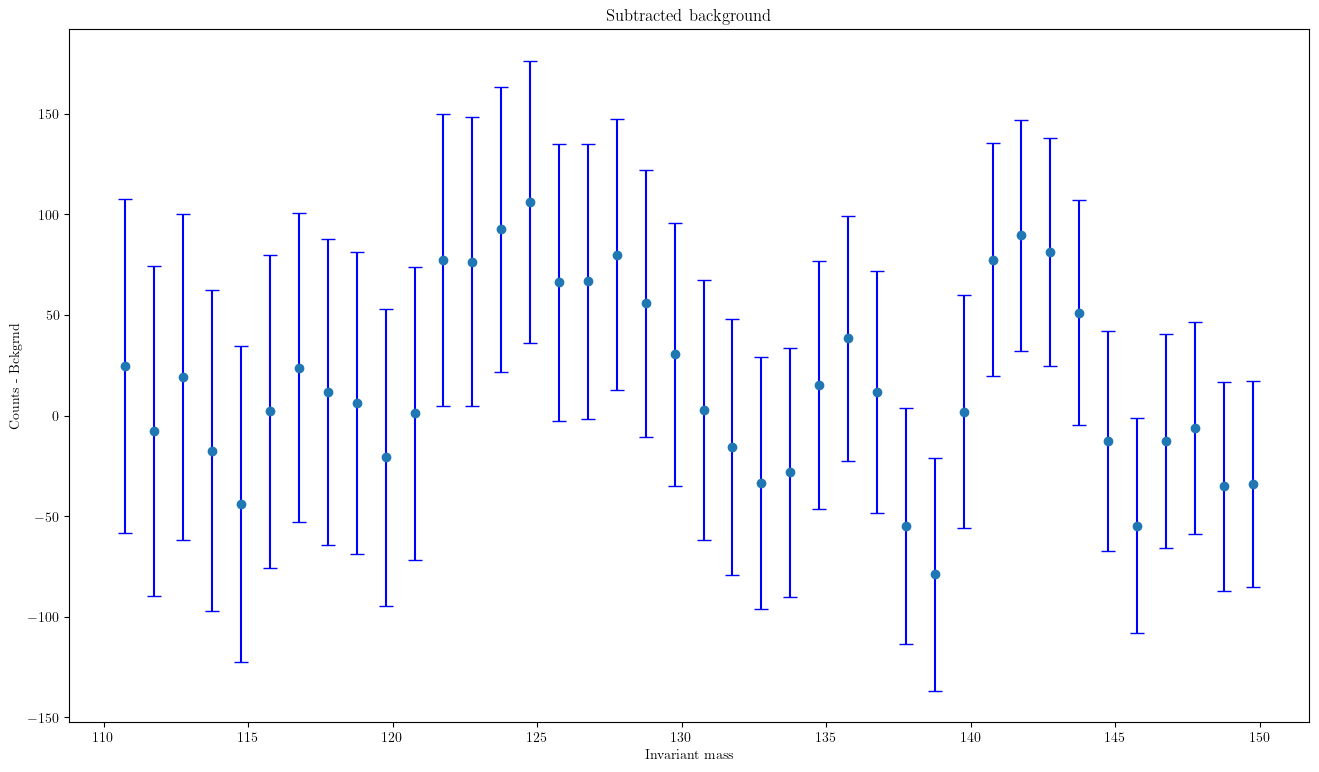

In [168]:
lower, upper = 110, 150
def model(x, a, b, c):
    return a * np.exp(b * x + c*x**2)
ign_lower, ign_upper = 120, 130
mask = (x >= lower) & (x <= upper) & ((x <= ign_lower) | (x > ign_upper)) 
popt, pcov = curve_fit(model, x[mask], y[mask], p0=(50000, -0.01, -0.00))
print(popt)
fig = plt.figure()
plt.title('Sliding Epanechnikov Counts')
plt.xlabel('Invariant mass')
plt.ylabel('Counts')
fig.set_size_inches((16,9))
plt.scatter(x[lower:upper],y[lower:upper])
plt.plot(x[lower:upper], model(x[lower:upper], *popt), label='Fitted function', color='r')
plt.yscale('log')
plt.savefig('xgb_epanechnikov_linear.pdf')

plt.show()
fig = plt.figure()
plt.title('Subtracted background')
plt.xlabel('Invariant mass')
plt.ylabel('Counts - Bckgrnd')
fig.set_size_inches((16,9))
pl_lower, pl_upper = 110,150
#plt.scatter(x[pl_lower:pl_upper],y[pl_lower:pl_upper]-model(x[pl_lower:pl_upper], *popt))
plt.errorbar(x[pl_lower:pl_upper],y[pl_lower:pl_upper]-model(x[pl_lower:pl_upper], *popt), yerr=np.sqrt(y[pl_lower:pl_upper]), fmt='o', ecolor='b', capsize=5, label='Asymmetrical error bars')
plt.savefig('xgb_epanechnikov_detrended.pdf')

plt.show()

## Fit Gauß

[125.04341259   7.30011485  98.28757538]


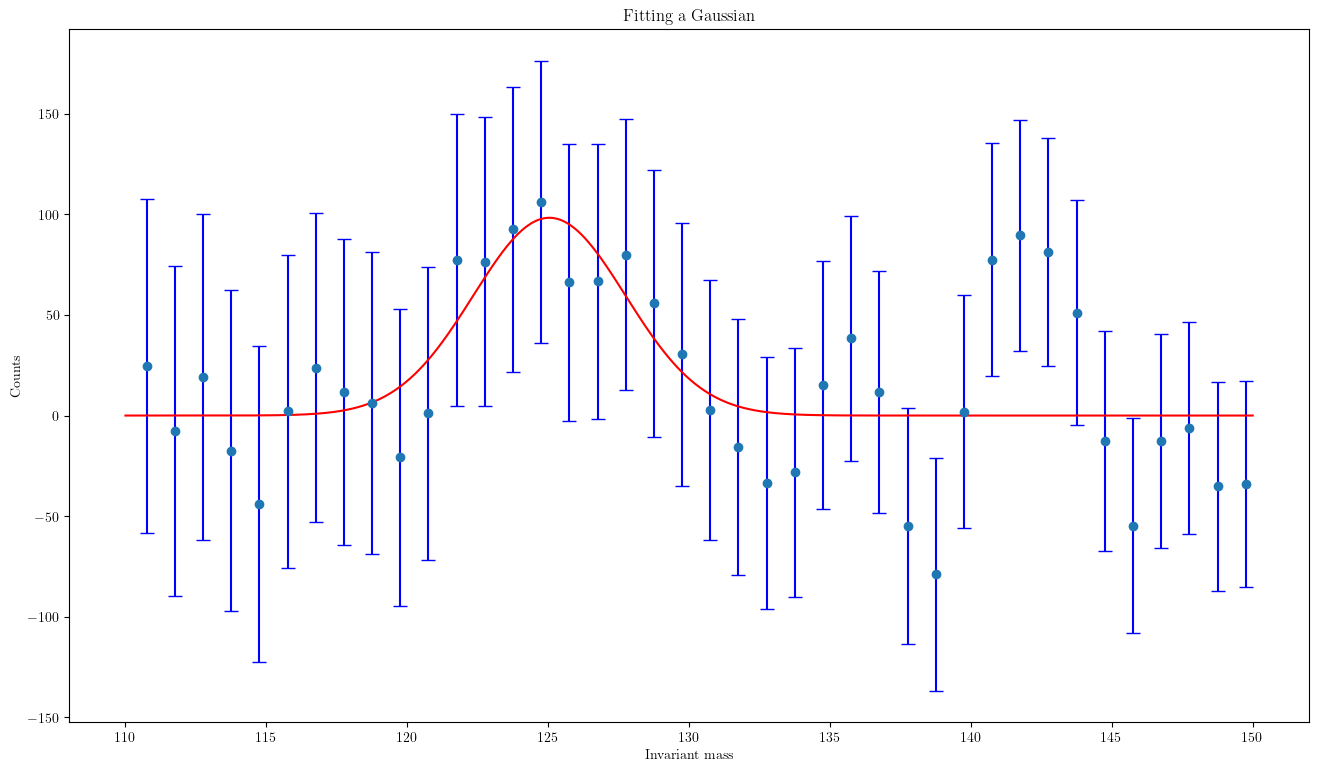

In [169]:
def gauß(x,a,b,c):
    return np.exp(-(x-a)**2/(2*b))*c
gx = x[pl_lower:pl_upper]
gy = y[pl_lower:pl_upper]-model(x[pl_lower:pl_upper], *popt)
gpopt, gpcov = curve_fit(gauß, gx, gy, p0=(125, 1, 50))
print(gpopt)
fig = plt.figure()
fig.set_size_inches((16,9))
plt.title('Fitting a Gaussian')
plt.xlabel('Invariant mass')
plt.ylabel('Counts')
plt.errorbar(x[pl_lower:pl_upper],y[pl_lower:pl_upper]-model(x[pl_lower:pl_upper], *popt), yerr=np.sqrt(y[pl_lower:pl_upper]), fmt='o', ecolor='b', capsize=5, label='Asymmetrical error bars')

plt.plot(np.linspace(pl_lower,pl_upper,1000), gauß(np.linspace(pl_lower,pl_upper,1000), *gpopt), label='Fitted Gaussian', color='r')
plt.savefig('xgb_epanechnikov_gaußfit.pdf')

plt.show()

# Testing $H_0$

In [155]:
np.std(gy) 

46.64302490665284